# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = len(data)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data["income"] == '>50K'])

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data["income"] == '<=50K'])

percentage = float(n_greater_50k) / n_records * 100
# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = percentage

# Print the results
print percentage
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

24.7843969749
Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

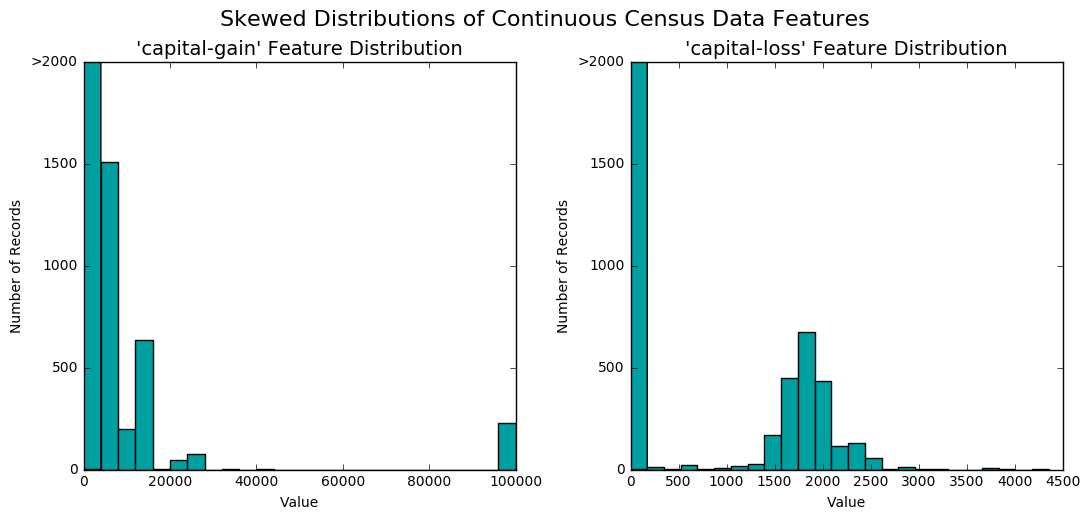

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

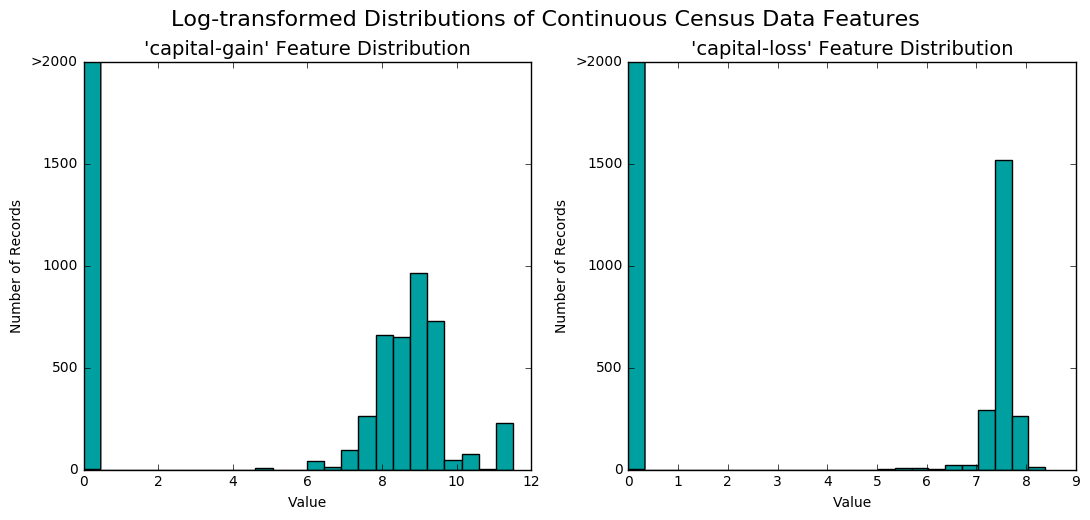

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.map(lambda x: 0 if x == "<=50K" else 1)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
#print encoded

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [8]:
# TODO: Calculate accuracy
accuracy = greater_percent / 100

# TODO: Calculate F-score using the formula above for beta = 0.5
beta = .5
fscore = (1 + (.5 **2)) * ((accuracy * 1)/((.5**2 * accuracy)+1)) 

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **

**Gaussian Naive Bayes: **
- * As seen in the udacity lessons, GaussianNB can be used for email classification and word processing. Depending on how much sample text it is given, it can be relatively good at providing predictions for a missing word based on the words around it. It can also classify emails based on the occurence and frequency of words that appear in them. 

- * According to Oracle documentation, Naive Bayes is very fast and scalable when it comes to model building and scoring. The Naive Bayes classifier only requires one scan of the database to look up probabilities and make predictions. The Naive Bayes classifier scales linearly when adding more predictors and rows of data. It can also be used for both binary and multiclass classification problems. Naive Bayes also does not require lots of training data to make reliable predictions. The implementation of it is considered to be relatively simple.

- * One of the big disadvantages of Naive Bayes according to many sources is its assumption of class conditional independence. It assumes that the variables it is analyzing are independent of each other which is often not true in many real world scenarios. Variables such as age and income are definitely not directly related but do have some degree of influence over each other. Another issue that arises with Naive Bayes is the Zero Conditional Probability Problem. If a feature that the algorithm is searching for never occurs, then the probabilty for that feature is set to 0, which can cause a prediction to become 0 when it is multiplied by the probabilities of other features. This can cause the probabilities of other features to become irrelevant when they actually are. Many statisticians like to correct the Zero Conditional Probability problem by using Laplace Smoothing which involves adding a very small number, such as 1, to all feature counts so that a probabilty is never zero.

- * This model is a good candiate for predicting charity donors because we have a dataset with many features that we are trying to analyze to predict whether an individual is a donor or not. Naive Bayes will be effective in this situation because the prediction we are trying to make is binary, whether an individual makes more than 50k or not. It will also perform the calculations quickly and scale well if we decide to add more data.

**Support Vector Machines: **

- * Support Vector Machines have been used a lot in the field of image recognition and classification and are considered effective in the field of computer vision.

- * Support Vector Machines work very well in complicated domains where there is a clear margin of seperation in the data. They work well for datasets that have many dimensions and many features of a class are being analyzed. Support Vector Machines also make use of kernels, which make them very effective at modeling nonlinear relationships in the data.

- * One major weakness for Support Vector Machines is that training time increases exponentially as the size of the data set increases. They do not work well with data that is very "noisey", when classes are overlapping, because the margin of seperation is difficult to find in these scenarios.

- * A support vector machine could be a good choice for this data because we have data with many features and few classes. The decision boundary we are trying to create in the data is between individuals that make over 50k and ones that don't. A support vector machine would be good at finding this decision boundary because it can take into account many features of the individuals with its usage of kernels.

**Logistic Regression: **

- * Logistic regression is used a lot in the field of medicine to predict whether an inidvidual has a disease or not based on their characteristics and the results of blood tests.

- * One advantage of logistic regression is that the dependent variables being analyzed do not have to have a normal distribution or equal variance within groups for the regression to produce meaningful results. Logistic regression is relatively simple to train and is computationally efficient.

- * A disadvantage of logistic regression that many sources suggest is that it tends to have high bias and low variance. Logistic regression splits the data with a linear decision boundary, so if the data is scattered in clusters, it will be difficult for logistic regression to properly classify it. Sources also suggest that logistic regression requires large sample sizes to achieve results that are stable so it seems that logistic regression is sensitive to changes in data size

- * Logistic regression may be a good choice for this problem because the outcome variable we are trying to predict is binary, whether an individual makes over 50k or not. Logistic regression is also good at working with independent variables of different types, which this dataset definitely includes.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [11]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
        
    results = {}
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    # Adjusting size of training and testing data with sample size
    X_train = X_train[:sample_size]
    y_train = y_train[:sample_size]
    X_test = X_test[:sample_size]
    y_test = y_test[:sample_size]
    
    start = time() # Get start time
    learner.fit(X_train, y_train)
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start     
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train, predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train, predictions_train, beta = .5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = .5)
       
    # Success
    print "{} trained on {} samples. Train Time: {}. Pred Time: {}. Acc Train: {}. Acc Test: {}. F Train: {}. F Test: {}".format(learner.__class__.__name__, sample_size, results['train_time'], results['pred_time'], results['acc_train'], results['acc_test'], results['f_train'], results['f_test'] )
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

GaussianNB trained on 361 samples. Train Time: 0.00587606430054. Pred Time: 0.00610995292664. Acc Train: 0.387811634349. Acc Test: 0.368421052632. F Train: 0.322085889571. F Test: 0.308219178082
GaussianNB trained on 3617 samples. Train Time: 0.0224149227142. Pred Time: 0.0636999607086. Acc Train: 0.362455073265. Acc Test: 0.361349184407. F Train: 0.316181953766. F Test: 0.310929412647
GaussianNB trained on 36177 samples. Train Time: 0.209454059601. Pred Time: 0.165965795517. Acc Train: 0.609807336153. Acc Test: 0.608291873964. F Train: 0.434045245677. F Test: 0.428112885072
LogisticRegression trained on 361 samples. Train Time: 0.00392913818359. Pred Time: 0.00153994560242. Acc Train: 0.853185595568. Acc Test: 0.82271468144. F Train: 0.709459459459. F Test: 0.606060606061
LogisticRegression trained on 3617 samples. Train Time: 0.0228002071381. Pred Time: 0.0100448131561. Acc Train: 0.845175559856. Acc Test: 0.838816698922. F Train: 0.687256538676. F Test: 0.66289527125
LogisticRegress

/Users/nikhilsharma/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 3617 samples. Train Time: 2.26408600807. Pred Time: 2.05227613449. Acc Train: 0.829969588056. Acc Test: 0.822228366049. F Train: 0.653465346535. F Test: 0.61845217979
SVC trained on 36177 samples. Train Time: 136.129304886. Pred Time: 120.499449968. Acc Train: 0.832269121265. Acc Test: 0.830071862908. F Train: 0.674464332186. F Test: 0.659237536657


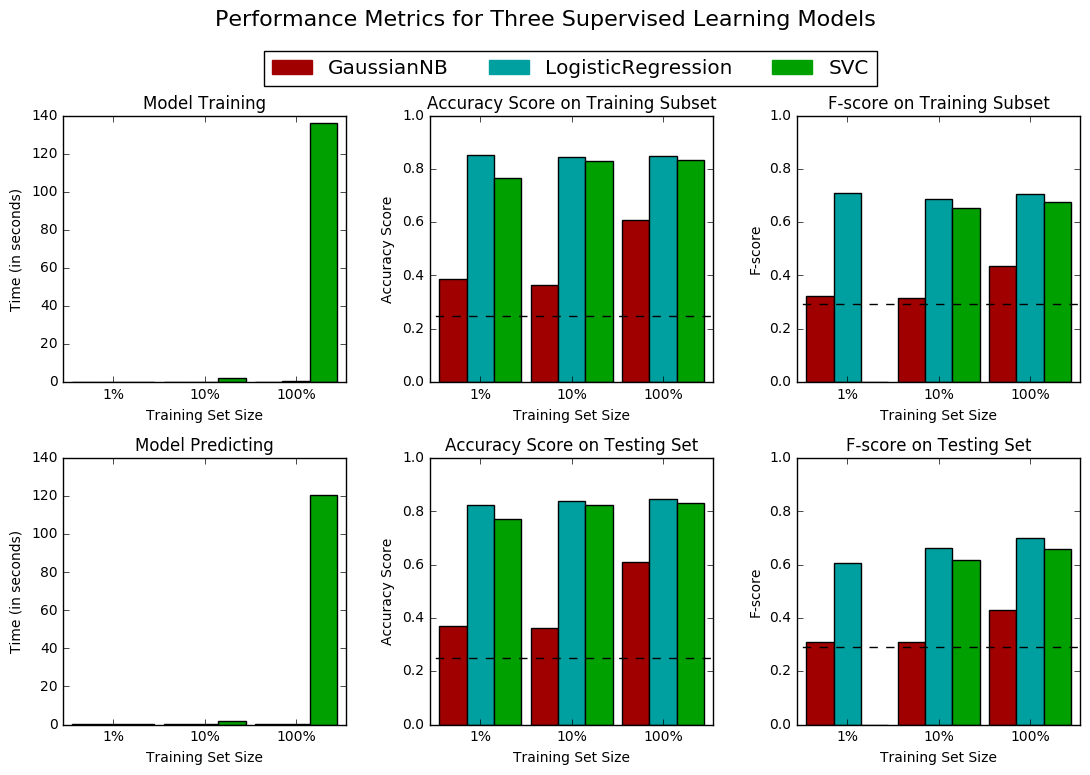

In [13]:
# TODO: Import the three supervised learning models from sklearn
from sklearn import svm
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB

# TODO: Initialize the three models
clf_A = GaussianNB() #GaussianNB
clf_B = linear_model.LogisticRegression()
clf_C = svm.SVC()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(len(X_train) * .01)
samples_10 = int(len(X_train) * .1)
samples_100 = int(len(X_train))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: ** Based on analysis of the charts above and the training times and prediction times of each model, logistic regression definitely seems to be the best choice for identifying individuals that make more than $50,000. It had the highest accuracy when making predictions on both the training and testing sets at all sample sizes. Logistic regression also had the best f-scores in comparison to the other two models, meaning that it had a better average of precision and recall then them. The only area where it scored less was training time in comparsion to GaussianNB. GaussianNB had a training time of .209s while Logistic Regression had a time of .722s for the full dataset. At a dataset of this size, a difference of .5s in training time does not seem like a good reason to pick GaussianNB over Logistic Regression. However, if the dataset were to increase by 10x or 100x, it could definitely become a more important factor to consider.

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** In this problem, we are attempting to make a binary prediction, whether an individual makes over 50k or not. When the training data is fitted to the Logistic Regression model, the model takes the training data and produces probabilties for whether an individual makes more than 50k or not based on features of that individual. The model then weights the probabilties of features that it determines to be more important in predicting whether an individual makes over 50k or not. The model then creates a regression line based on the weighted probabilities. Finally, the model implements a optimization procedure to determine which probabilties best predict whether an individual makes over 50k or not.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [17]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
clf = linear_model.LogisticRegression()

# TODO: Create the parameters list you wish to tune
parameters = {'solver': ['newton-cg', 'lbfgs', 'sag'],
              'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
              'max_iter': [100, 1000]}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta = .5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

/Users/nikhilsharma/anaconda/lib/python2.7/site-packages/sklearn/linear_model/sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8483
F-score on testing data: 0.6993

Optimized Model
------
Final accuracy score on the testing data: 0.8494
Final F-score on the testing data: 0.7008


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |       .2478         |    .8483          |      .8494      |
| F-score        |       .2917         |    .6993          |      .7008      |


**Answer: ** The scores in the optimized model are only slightly better than the unoptimized model, there is a difference of .0001 and .0008 in accuracy and f-score. However, the scores are far better than those in the benchmark predictor.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:** The five features that I believe are most important in order are education-num, education_level, occupation, age, and hours-per-week. It has been statistically shown by many studies that individuals with higher education_levels have higher average salaries. I selected occupation because there are certain occupations such as doctors and lawyers that tend to have average salaries well over 50k. I picked age because, people generally make more money as they grow older. I picked hours-per-week as the last one because it seems like it would be difficult to earn a high salary without atleast working 40 hrs a week.


### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

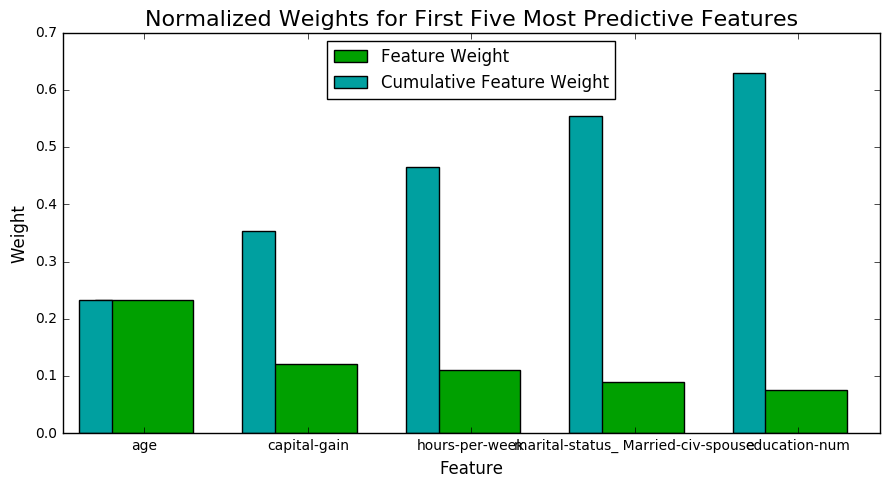

In [19]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier

# TODO: Train the supervised model on the training set 
model = RandomForestClassifier(random_state=123)
model.fit(X_train, y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:** Three of the features I predicted in Question 6 were selected among the five most important features by the RandomForestClassifier. They were age, hours-per-week, and education-num. However, I did not expect education-num to have the least importance out of the five, I predicted it to be the most important. I also did not expect age to be classified as the most important and have a greater weight than hours-per-week and education-num combined. This somewhat makes sense because even if an individual just got a high level degree and is working a lot of hours, it may take some some time before a company starts to value them and gives them a good salary.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [20]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8494
F-score on testing data: 0.7008

Final Model trained on reduced data
------
Accuracy on testing data: 0.8347
F-score on testing data: 0.6678


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:** The scores of the Final Model on reduced data were lower than the scores of the Final model trained on full data. I would only consider training time as a factor for using reduced data if it was very urgent for the report to be produced. For example, if there is a meeting deadline in 2 hours. I would certainly let the people who are reading the report know that reduced data was used and that potentially a more accurate report could be produced if more time were available. I really think that compromising accuracy in a report can be detrimental to machine learning in the long run.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.